In [1]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import math
from sklearn.model_selection import train_test_split
from timeit import default_timer
from matplotlib.ticker import FormatStrFormatter
import deepxde as dde
import time

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


In [2]:
def set_size(width, fraction=1, subplots=(1, 1), height_add=0):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float or string
            Document width in points, or string of predined document type
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    if width == 'thesis':
        width_pt = 426.79135
    elif width == 'beamer':
        width_pt = 307.28987
    else:
        width_pt = width

    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = height_add + fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)

tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "times",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 12,
    "font.size": 12,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10
}

plt.rcParams.update(tex_fonts)

In [3]:
X = 1
dx = 0.01
nx = int(round(X/dx))
spatial = np.linspace(dx, X, nx)
T = 12
dt = 0.0005
nt = int(round(T/dt))
temporal = np.linspace(0, T, nt)

In [4]:
def solveBetaFunction(x, gamma):
    beta = np.zeros(len(x), dtype=np.float32)
    for idx, val in enumerate(x):
        beta[idx] = 5*math.cos(gamma*math.acos(val))
    return beta

def solveKernelFunction(beta, dx):
    kappa = np.zeros(len(beta))
    for i in range(0, len(beta)):
        kappa[i] = (sum(kappa[i:0:-1]*beta[0:i])*dx - beta[i])
    return kappa

def solveControl(u, kernel, nx, dx):
    k = np.flip(kernel)
    return sum(k[0:nx]*u[0:nx])*dx

def solveOpen(u, kernel, nx, dx):
    return 0


def solveW(u, kernel, dx):
    k = np.flip(kernel)
    w = np.zeros(len(kernel))
    for i in range(0, len(k)):
        w[i] = u[i]-sum(k[i:0:-1]*u[0:i])*dx
    return w

def solveWIntegral(x, w, dx):
    return sum(w[0:]**2 * np.exp(x)[0:])*dx

def calculateLyapunov(x, u, k, dx, gamma, beta, betaEst):
    w = solveW(u, k, dx)
    wInt = solveWIntegral(x, w, dx)
    return 0.5*(np.log(1+wInt) + 1/gamma * sum((beta-betaEst)**2)*dx)

def estimateBetaHatDelta(x, u, k, dx, gamma):
    w = solveW(u, k, dx)
    wInt = solveWIntegral(x, w, dx)
    betaHat = np.zeros(len(x))
    expSpatial = np.exp(x)
    for i in range(0, len(betaHat)):
        uTerm = (expSpatial[i]*w[i] - sum(expSpatial[i:]*k[0:len(k)-i]*w[i:])*dx)*u[0]
        betaHat[i] = gamma/(1+wInt)*uTerm
    return betaHat, wInt, uTerm

def solvePDEAdaptive(I, a, L, dt,F, T, gamma, beta, betaDeltaEstimator, kernelEstimator, solveControl):
    Nt = int(round(T/float(dt)))
    t = np.linspace(0, Nt*dt, Nt)  
    dx = np.sqrt(a*dt/F)
    Nx = int(round(L/dx))
    x = np.linspace(0, L, Nx)      
    # Make sure dx and dt are compatible with x and t
    dx = x[1] - x[0]
    dt = t[1] - t[0]
    bArr = []
    kArr = []
    u = np.zeros((Nt, Nx))
    # Guess beta to be all ones
    betaHat = np.ones(Nx)
    bArr.append(betaHat)
    l = []


    # Set initial condition u(x,0) = I(x)
    for i in range(0, Nx):
        u[0][i] = I[i]

    for i in range(1, Nt):
        kEst = kernelEstimator(betaHat, dx)
        kArr.append(kEst)
        if i % int(Nt/10) == 0:
            print("i", i, "/", Nt, wTerm, uTerm)
        l.append(calculateLyapunov(x, u[i-1], kEst, dx,gamma, beta, betaHat))
        u[i][0:Nx-1] = u[i-1][0:Nx-1] + dt*((u[i-1][1:Nx] - u[i-1][0:Nx-1])/dx + (u[i-1][0]*beta)[0:Nx-1])
        # Insert boundary conditions
        # Compute BetaHat Estimate
        bHatDelta, wTerm, uTerm = estimateBetaHatDelta(x, u[i-1], kEst, dx, gamma)
        # Eulers
        betaHat = betaHat + dt*bHatDelta
        u[i][-1] = solveControl(u[i-1], kEst, Nx, dx)
        bArr.append(betaHat)
    return u, bArr, l, kArr

def solvePDE(I, a, L, dt,F, T, gamma, beta, solveControl):
    Nt = int(round(T/float(dt)))
    t = np.linspace(0, Nt*dt, Nt)  
    dx = np.sqrt(a*dt/F)
    Nx = int(round(L/dx))
    x = np.linspace(0, L, Nx)      
    # Make sure dx and dt are compatible with x and t
    dx = x[1] - x[0]
    dt = t[1] - t[0]
    u = np.zeros((Nt, Nx))
    
    # Set initial condition u(x,0) = I(x)
    for i in range(0, Nx):
        u[0][i] = I[i]
    kEst = solveKernelFunction(beta, dx)
    for i in range(1, Nt):
        if i % int(Nt/10) == 0:
            print("i", i, "/", Nt)
        u[i][0:Nx-1] = u[i-1][0:Nx-1] + dt*((u[i-1][1:Nx] - u[i-1][0:Nx-1])/dx + (u[i-1][0]*beta)[0:Nx-1])
        u[i][-1] = solveControl(u[i-1], kEst, Nx, dx)
    return u

# PDE L2 Error
def getPDEl2(u, uhat):
    pdeError = np.zeros(nt-1)
    for i in range(1, nt):
        error = 0
        for j in range(nx):
            error += (u[i][j] - uhat[i][j])**2
        error = np.sqrt(error)
        pdeError[i-1] = error
    return pdeError

In [5]:
# Dataset generation # Uncomment to generate own dataset
from tqdm import tqdm

init_cond = np.ones(len(spatial))
gamma = 0.5
beta = solveBetaFunction(spatial, 3.2)
xArr = []
yArr = []
# Build Dataset
for i in range(10):
    beta = solveBetaFunction(spatial, np.random.uniform(2.7, 3.2))
    _, bHat, _ = solvePDEAdaptive(init_cond, 1, 1, dt, dt / dx ** 2, T, gamma, beta, estimateBetaHatDelta,
                                  solveKernelFunction, solveControl)
    for j in range(1000):
        xArr.append(bHat[j * 20])
        yArr.append(solveKernelFunction(bHat[j * 20], dx))
xArr = np.array(xArr)
yArr = np.array(yArr)
# np.savetxt("x.dat", xArr)
# np.savetxt("y.dat", yArr)

KeyboardInterrupt: 

In [174]:
# Parameters
epochs =500
ntrain = 900
ntest = 100
batch_size = 100
gamma = 0.5
learning_rate = 0.001
step_size= 50

grid = np.array(spatial, dtype=np.float32).reshape(len(spatial), 1)
grid = torch.from_numpy(grid).cuda()

In [175]:
# Create train/test splits
x = np.loadtxt("x.dat", dtype=np.float32)
y = np.loadtxt("y.dat", dtype=np.float32)
print(x.shape)
x = x.reshape(x.shape[0], x.shape[1])
y = y.reshape(y.shape[0], y.shape[1])
print(x.shape)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=1)
x_train = torch.from_numpy(x_train).cuda()
y_train = torch.from_numpy(y_train).cuda()
x_test = torch.from_numpy(x_test).cuda()
y_test = torch.from_numpy(y_test).cuda()

trainData = DataLoader(TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True, generator=torch.Generator(device='cuda'))
testData = DataLoader(TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False, generator=torch.Generator(device='cuda'))

(10000, 100)
(10000, 100)


In [176]:
def count_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

In [177]:
# Define a sequential torch network for batch and trunk. Can use COV2D which we will show later
dim_x = 1
m = len(spatial)
model = dde.nn.DeepONetCartesianProd([m, 64, 64], [dim_x, 64, 64], "relu", "Glorot normal").cuda()
print(count_params(model))

14913


In [178]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

In [179]:
loss = torch.nn.MSELoss()
train_lossArr = []
test_lossArr = []
time_Arr = []

for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_loss = 0
    for x, y in trainData:
        x, y = x.cuda(), y.cuda()
        optimizer.zero_grad()
        out = model((x, grid))

        lp = loss(out, y)
        lp.backward()
        
        optimizer.step()
        train_loss += lp.item()
        
    scheduler.step()
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for x, y in testData:
            x, y = x.cuda(), y.cuda()
            
            out = model((x, grid))
            test_loss += loss(out, y).item()
            
    train_loss /= len(trainData)
    test_loss /= len(testData)
    
    train_lossArr.append(train_loss)
    test_lossArr.append(test_loss)
    
    t2 = default_timer()
    time_Arr.append(t2-t1)
    if ep%50 == 0:
        print(ep, t2-t1, train_loss, test_loss)

0 0.21680537797510624 2.3380575597286226 0.671496108174324
50 0.14765646203886718 0.004264767894831796 0.005310940183699131
100 0.14699244208168238 0.0030906604525322715 0.0022749515250325204
150 0.14190201100427657 0.0025333124219388183 0.002274167304858565
200 0.14219670603051782 0.002318004468947442 0.0022918324917554854
250 0.14321790100075305 0.0022167132772867464 0.001995322306174785
300 0.17720958800055087 0.0021695419596249443 0.0018620377406477929
350 0.15056331199593842 0.00213329491024423 0.001918149704579264
400 0.1466689450899139 0.0021101432729564193 0.0018400500644929706
450 0.17187937698327005 0.002100538362800661 0.0018703909241594373


Avg Epoch Time: 0.1525536667802371
Final Testing Loss: 0.0018790414440445602
Final Training Loss: 0.0020983942441590545


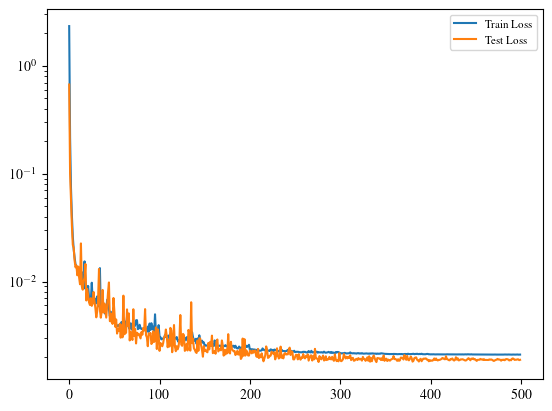

In [180]:
# Display Model Details
plt.figure()
plt.plot(train_lossArr, label="Train Loss")
plt.plot(test_lossArr, label="Test Loss")
plt.yscale("log")
plt.legend()

testLoss = 0
trainLoss = 0
with torch.no_grad():
    for x, y in trainData:
        x, y = x.cuda(), y.cuda()

        out = model((x, grid))
        out = out.reshape((out.shape[0], out.shape[1]))
        trainLoss += loss(out.view(batch_size, -1), y.view(batch_size, -1)).item()
        
    for x, y in testData:
        x, y = x.cuda(), y.cuda()

        out = model((x, grid))
        out = out.reshape((out.shape[0], out.shape[1]))
        testLoss += loss(out.view(batch_size, -1), y.view(batch_size, -1)).item()
    
    
print("Avg Epoch Time:", sum(time_Arr)/len(time_Arr))
print("Final Testing Loss:", testLoss/len(testData))
print("Final Training Loss:", trainLoss/len(trainData))

In [181]:
torch.save(model.state_dict(),"adaptiveControlModel")
model.load_state_dict(torch.load('adaptiveControlModel'))

<All keys matched successfully>

In [80]:
def nopKernel(beta, _):
    with torch.no_grad():
        b = torch.from_numpy(beta.reshape(1, len(beta)).astype(np.float32)).cuda()
        k = model((b, grid))
    return k.detach().cpu().numpy()[0]

T = 14
dt = 0.0005
nt = int(round(T/dt))
temporal = np.linspace(0, T, nt)
init_cond = np.ones(len(spatial))

# l is the Lyapunov function 
beta = solveBetaFunction(spatial, 2.9)
uopen = solvePDE(init_cond, 1, 1, dt, dt/dx**2, T, 1, beta, solveOpen)
u, bHat, l, k = solvePDEAdaptive(init_cond, 1, 1, dt, dt/dx**2, T, gamma, beta, estimateBetaHatDelta, solveKernelFunction, solveControl)
uNop, bHatNop, lNop, kNop = solvePDEAdaptive(init_cond, 1, 1, dt, dt/dx**2, T, gamma, beta, estimateBetaHatDelta, nopKernel, solveControl)
beta = solveBetaFunction(spatial, 3.1)
uopen2 = solvePDE(init_cond, 1, 1, dt, dt/dx**2, T, 1, beta, solveOpen)
u2, bHat2, l2, k2 = solvePDEAdaptive(init_cond, 1, 1, dt, dt/dx**2, T, gamma, beta, estimateBetaHatDelta, solveKernelFunction, solveControl)
uNop2, bHatNop2, lNop2, kNop2 = solvePDEAdaptive(init_cond, 1, 1, dt, dt/dx**2, T, gamma, beta, estimateBetaHatDelta, nopKernel, solveControl)

i 2800 / 28000
i 5600 / 28000
i 8400 / 28000
i 11200 / 28000
i 14000 / 28000
i 16800 / 28000
i 19600 / 28000
i 22400 / 28000
i 25200 / 28000
i 2800 / 28000 0.38576345700148673 -0.27810659683547007
i 5600 / 28000 2.1766636526020395 0.05598539770944812
i 8400 / 28000 4.697188597655273 -0.02771736147048696
i 11200 / 28000 5.418698410169838 0.15884446513366493
i 14000 / 28000 7.288266583202939 -0.6254463084715586
i 16800 / 28000 7.72105164810782 -6.923527855865375
i 19600 / 28000 2.587535084213862 -1.082698465960254
i 22400 / 28000 0.05110882891480137 0.012719090756256548
i 25200 / 28000 0.00013055444257895928 -0.0002151011575088879
i 2800 / 28000 0.3737728458263132 -0.26738314984741995
i 5600 / 28000 2.121802372953122 0.05521682866387027
i 8400 / 28000 4.6062705322099 -0.02491343259109462
i 11200 / 28000 5.389726207170995 0.17712815406753107
i 14000 / 28000 7.226295881252917 -0.3583468740831018
i 16800 / 28000 7.482843090940918 -6.674072472050862
i 19600 / 28000 2.4698839082983595 -1.0715

In [44]:
print(uopen.shape)
print(uNop.shape)

(28000, 100)
(28000, 100)


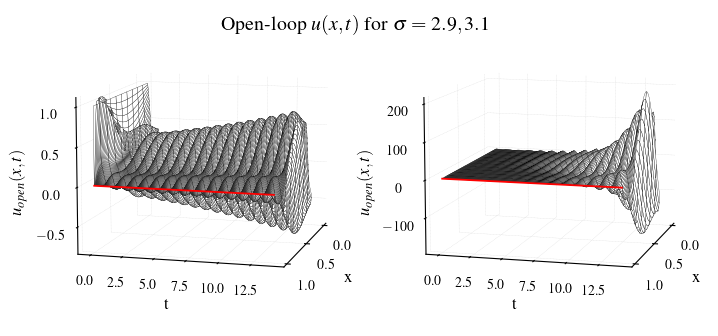

In [92]:
res = 1
fig = plt.figure(figsize=set_size(516, 0.99, (1,2), height_add=1))

subfigs = fig.subfigures(nrows=1, ncols=1, hspace=0)

subfig = subfigs
subfig.subplots_adjust(left=0.06, bottom=0, right=1, top=1, wspace=0.1, hspace=0)
subfig.suptitle(r"Open-loop $u(x, t)$ for $\sigma=2.9, 3.1$")
axes = subfig.subplots(nrows=1, ncols=2, subplot_kw={"projection": "3d", "computed_zorder": False})
for ax in axes:
    for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
        axis._axinfo['axisline']['linewidth'] = 1
        axis._axinfo['axisline']['color'] = "b"
        axis._axinfo['grid']['linewidth'] = 0.2
        axis._axinfo['grid']['linestyle'] = "--"
        axis._axinfo['grid']['color'] = "#d1d1d1"
        axis.set_pane_color((0, 0, 0))
    
meshx, mesht = np.meshgrid(spatial, temporal)
                     
axes[0].plot_surface(meshx, mesht, uopen, edgecolor="black",lw=0.2, rstride=40, cstride=10, 
                        alpha=1, color="white", shade=False, rasterized=True, antialiased=True)
test = np.ones(nt)
vals = (uopen.transpose())[-1] 
axes[0].plot(test[1:], temporal[1:], vals[1:], color="red", lw=1.3, antialiased=True)
axes[0].view_init(10, 15)
axes[0].set_xlabel("x")
axes[0].set_ylabel("t")
axes[0].set_zlabel(r"$u_{open}(x, t)$", rotation=90)
axes[0].zaxis.set_rotate_label(False)
axes[0].set_xticks([0, 0.5, 1])
axes[0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

                     
axes[1].plot_surface(meshx, mesht, uopen2, edgecolor="black",lw=0.2, rstride=70, cstride=10, 
                        alpha=1, color="white", shade=False, rasterized=True, antialiased=True)
test = np.ones(nt)
vals = (uopen.transpose())[-1] 
axes[1].plot(test[1:], temporal[1:], vals[1:], color="red", lw=1.3, antialiased=True)
axes[1].view_init(10, 15)
axes[1].set_xlabel("x")
axes[1].set_ylabel("t")
axes[1].set_zlabel(r"$u_{open}(x, t)$", rotation=90)
axes[1].zaxis.set_rotate_label(False)
axes[1].set_xticks([0, 0.5, 1])
axes[1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

plt.savefig("adaptiveOpenLoopExamples.pdf", dpi=300)

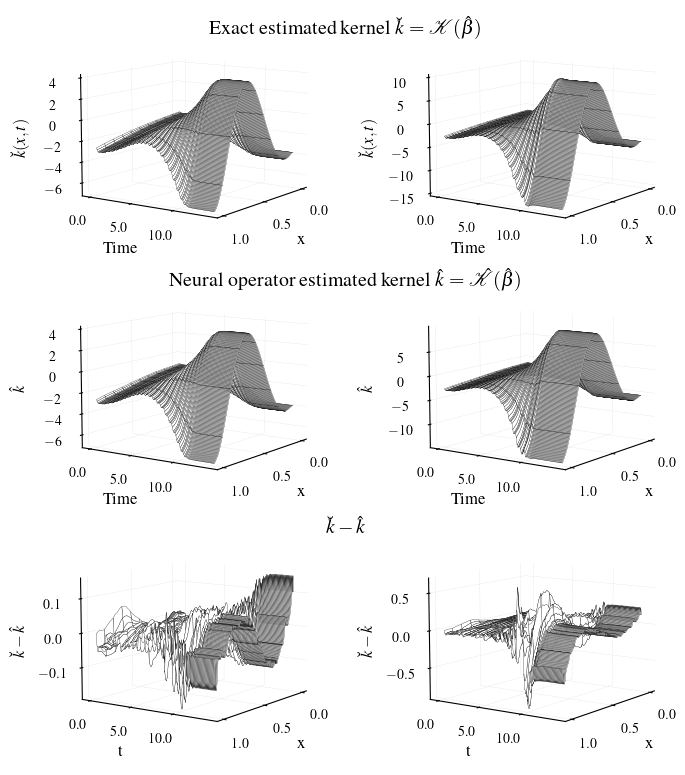

In [91]:
res = 1
fig = plt.figure(figsize=set_size(516, 0.99, (3,2), height_add=1))

subfigs = fig.subfigures(nrows=3, ncols=1, hspace=0)

subfig = subfigs[0]
subfig.suptitle(r"Exact estimated kernel $\breve k = \mathcal{K}(\hat{\beta})$")
subfig.subplots_adjust(left=0.06, bottom=0, right=1, top=1, wspace=0.1, hspace=0)
k = np.array(k)
k2 = np.array(k2)
kNop = np.array(kNop)
kNop2 = np.array(kNop2)

axes = subfig.subplots(nrows=1, ncols=2, subplot_kw={"projection": "3d", "computed_zorder": False})

for ax in axes:
    for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
        axis._axinfo['axisline']['linewidth'] = 1
        axis._axinfo['axisline']['color'] = "b"
        axis._axinfo['grid']['linewidth'] = 0.2
        axis._axinfo['grid']['linestyle'] = "--"
        axis._axinfo['grid']['color'] = "#d1d1d1"
        axis.set_pane_color((0, 0, 0))
    
meshx, mesht = np.meshgrid(spatial, temporal[1:])

axes[0].plot_surface(meshx, mesht, k, edgecolor="black",lw=0.2, rstride=200, cstride=10, 
                        alpha=1, color="white", shade=False, rasterized=True, antialiased=True)
axes[0].view_init(10, 35)
axes[0].set_xlabel("x")
axes[0].set_ylabel("Time")
axes[0].set_zlabel(r"$\breve k(x, t)$", rotation=90)
axes[0].zaxis.set_rotate_label(False)
axes[0].set_xticks([0, 0.5, 1])
axes[0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

axes[1].plot_surface(meshx, mesht, k2, edgecolor="black",lw=0.2, rstride=200, cstride=10, 
                        alpha=1, color="white", shade=False, rasterized=True, antialiased=True)
axes[1].view_init(10, 35)
axes[1].set_xlabel("x")
axes[1].set_ylabel("Time")
axes[1].set_zlabel(r"$\breve k(x, t)$", rotation=90)
axes[1].zaxis.set_rotate_label(False)
axes[1].set_xticks([0, 0.5, 1])
axes[1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

subfig = subfigs[1]
subfig.subplots_adjust(left=0.06, bottom=0, right=1, top=1, wspace=0.1, hspace=0)

subfig.suptitle(r"Neural operator estimated kernel $\hat{k}=\hat{\mathcal{K}}(\hat{\beta})$")
axes = subfig.subplots(nrows=1, ncols=2, subplot_kw={"projection": "3d", "computed_zorder": False})

for ax in axes:
    for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
        axis._axinfo['axisline']['linewidth'] = 1
        axis._axinfo['axisline']['color'] = "b"
        axis._axinfo['grid']['linewidth'] = 0.2
        axis._axinfo['grid']['linestyle'] = "--"
        axis._axinfo['grid']['color'] = "#d1d1d1"
        axis.set_pane_color((0, 0, 0))
    
meshx, mesht = np.meshgrid(spatial, temporal[1:])
                     
axes[0].plot_surface(meshx, mesht, kNop, edgecolor="black",lw=0.2, rstride=200, cstride=10, 
                        alpha=1, color="white", shade=False, rasterized=True, antialiased=True)
axes[0].view_init(10, 35)
axes[0].set_xlabel("x")
axes[0].set_ylabel("Time")
axes[0].set_zlabel(r"$\hat{k}$", rotation=90)
axes[0].zaxis.set_rotate_label(False)
axes[0].set_xticks([0, 0.5, 1])
axes[0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

axes[1].plot_surface(meshx, mesht, kNop2, edgecolor="black",lw=0.2, rstride=200, cstride=10, 
                        alpha=1, color="white", shade=False, rasterized=True, antialiased=True)
axes[1].view_init(10, 35)
axes[1].set_xlabel("x")
axes[1].set_ylabel("Time")
axes[1].set_zlabel(r"$\hat{k}$", rotation=90)
axes[1].zaxis.set_rotate_label(False)
axes[1].set_xticks([0, 0.5, 1])
axes[1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

subfig = subfigs[2]
subfig.subplots_adjust(left=0.06, bottom=0, right=1, top=1, wspace=0.1, hspace=0)

subfig.suptitle(r"$\breve k -\hat{k}$")
axes = subfig.subplots(nrows=1, ncols=2, subplot_kw={"projection": "3d", "computed_zorder": False})

for ax in axes:
    for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
        axis._axinfo['axisline']['linewidth'] = 1
        axis._axinfo['axisline']['color'] = "b"
        axis._axinfo['grid']['linewidth'] = 0.2
        axis._axinfo['grid']['linestyle'] = "--"
        axis._axinfo['grid']['color'] = "#d1d1d1"
        axis.set_pane_color((0, 0, 0))
    
meshx, mesht = np.meshgrid(spatial, temporal[1:])
                     
axes[0].plot_surface(meshx, mesht, k-kNop, edgecolor="black",lw=0.2, rstride=200, cstride=10, 
                        alpha=1, color="white", shade=False, rasterized=True, antialiased=True)
axes[0].view_init(10, 35)
axes[0].set_xlabel("x")
axes[0].set_ylabel("t")
axes[0].set_zlabel(r"$\breve k-\hat{k}$", rotation=90)
axes[0].zaxis.set_rotate_label(False)
axes[0].set_xticks([0, 0.5, 1])
axes[0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

axes[1].plot_surface(meshx, mesht, k2-kNop2, edgecolor="black",lw=0.2, rstride=200, cstride=10, 
                        alpha=1, color="white", shade=False, rasterized=True, antialiased=True)
axes[1].view_init(10, 35)
axes[1].set_xlabel("x")
axes[1].set_ylabel("t")
axes[1].set_zlabel(r"$\breve k-\hat{k}$", rotation=90)
axes[1].zaxis.set_rotate_label(False)
axes[1].set_xticks([0, 0.5, 1])
axes[1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

plt.savefig("adaptiveKernels.pdf", dpi=300)

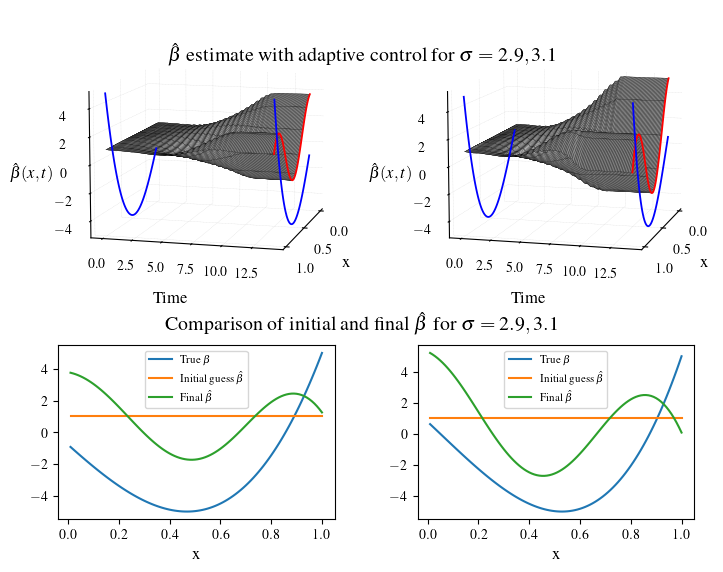

In [93]:
bHat= np.array(bHat)
bHat2 = np.array(bHat2)

res = 1
fig = plt.figure(figsize=set_size(516, 0.99, (2, 2), height_add=1))

subfigs = fig.subfigures(nrows=2, ncols=1, hspace=0)
subfig = subfigs[0]
subfig.subplots_adjust(left=0.07, bottom=0, right=1, top=1.1)
subfig.suptitle(r"$\hat{\beta}$ estimate with adaptive control for $\sigma=2.9, 3.1$")
axes = subfig.subplots(nrows=1, ncols=2, subplot_kw={"projection": "3d", "computed_zorder": False})

for ax in axes:
    for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
        axis._axinfo['axisline']['linewidth'] = 1
        axis._axinfo['axisline']['color'] = "b"
        axis._axinfo['grid']['linewidth'] = 0.2
        axis._axinfo['grid']['linestyle'] = "--"
        axis._axinfo['grid']['color'] = "#d1d1d1"
        axis.set_pane_color((0, 0, 0))
    
meshx, mesht = np.meshgrid(spatial, temporal)
                     
axes[0].plot_surface(meshx, mesht, bHat, edgecolor="black",lw=0.2, rstride=100, cstride=10, 
                        alpha=1, color="white", shade=False, rasterized=True, antialiased=True)
axes[0].view_init(10, 15)
axes[0].set_xlabel("x")
axes[0].set_ylabel("Time", labelpad=10)
axes[0].set_zlabel(r"$\hat{\beta}(x, t)$")
axes[0].zaxis.set_rotate_label(False)
axes[0].set_xticks([0, 0.5, 1])
axes[0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
beta = solveBetaFunction(spatial, 2.9)
vals = (bHat)[-1]
test = np.ones(int(nx))*temporal[-1]

axes[0].plot(spatial, test, vals, color="red", lw=1.3, antialiased=True)
axes[0].plot(spatial, test, beta, color="blue", lw=1.3, antialiased=True)
axes[0].plot(spatial, np.zeros(int(nx)), beta, color="blue", lw=1.3, antialiased=True)

axes[1].plot_surface(meshx, mesht, bHat2, edgecolor="black",lw=0.2, rstride=100, cstride=10, 
                        alpha=1, color="white", shade=False, rasterized=True, antialiased=True)

axes[1].view_init(10, 15)
axes[1].set_xlabel("x")
axes[1].set_ylabel("Time", labelpad=10)
axes[1].set_zlabel(r"$\hat{\beta}(x, t)$")
axes[1].zaxis.set_rotate_label(False)
axes[1].set_xticks([0, 0.5, 1])
axes[1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
beta = solveBetaFunction(spatial, 3.1)
vals = (bHat2)[-1] 
test = np.ones(int(nx))*temporal[-1]

axes[1].plot(spatial, test, vals, color="red", lw=1.3, antialiased=True)
axes[1].plot(spatial, test, beta, color="blue", lw=1.3, antialiased=True)
axes[1].plot(spatial, np.zeros(int(nx)), beta, color="blue", lw=1.3, antialiased=True)


subfig = subfigs[1]
subfig.suptitle(r"Comparison of initial and final $\hat{\beta}$ for $\sigma=2.9, 3.1$")

subfig.subplots_adjust(left=0.07, bottom=0.2, right=0.97, top=0.85, wspace=0.3, hspace=0.1)
axes = subfig.subplots(nrows=1, ncols=2)
beta = solveBetaFunction(spatial, 2.9)
axes[0].plot(spatial, beta, label=r"True $\beta$")
axes[0].plot(spatial, np.ones(len(beta)), label=r"Initial guess $\hat{\beta}$")
axes[0].plot(spatial, bHat[-1], label=r"Final  $\hat{\beta}$")
axes[0].legend()
axes[0].set_xlabel("x")


beta = solveBetaFunction(spatial, 3.1)
axes[1].plot(spatial, beta, label=r"True $\beta$")
axes[1].plot(spatial, np.ones(len(beta)), label=r"Initial guess $\hat{\beta}$")
axes[1].plot(spatial, bHat2[-1], label=r"Final  $\hat{\beta}$")
axes[1].legend()
axes[1].set_xlabel("x")
plt.savefig("betaComparison.pdf", dpi=300)

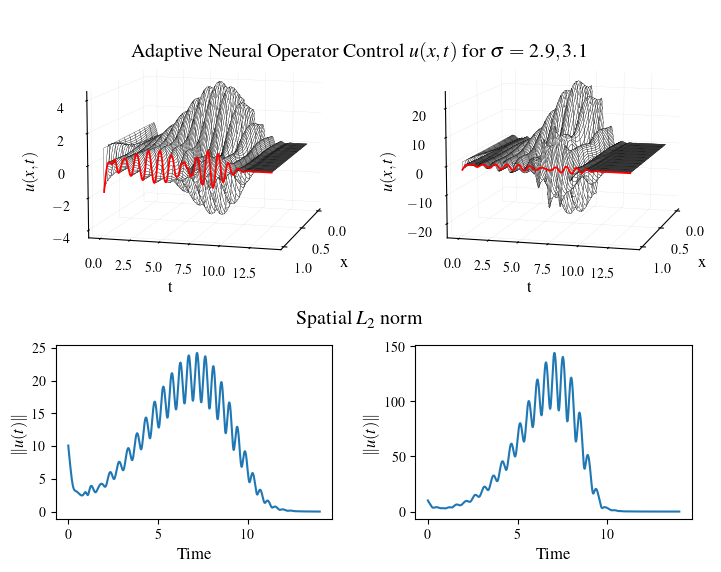

In [94]:
res = 1
fig = plt.figure(figsize=set_size(516, 0.99, (2,2), height_add=1))

subfigs = fig.subfigures(nrows=2, ncols=1, hspace=0)

subfig = subfigs[0]
subfig.subplots_adjust(left=0.07, bottom=0, right=1, top=1.1)
subfig.suptitle(r"Adaptive Neural Operator Control $u(x, t)$ for $\sigma=2.9, 3.1$")
axes = subfig.subplots(nrows=1, ncols=2, subplot_kw={"projection": "3d", "computed_zorder": False})

for ax in axes:
    for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
        axis._axinfo['axisline']['linewidth'] = 1
        axis._axinfo['axisline']['color'] = "b"
        axis._axinfo['grid']['linewidth'] = 0.2
        axis._axinfo['grid']['linestyle'] = "--"
        axis._axinfo['grid']['color'] = "#d1d1d1"
        axis.set_pane_color((0, 0, 0))
    
meshx, mesht = np.meshgrid(spatial, temporal)
                     
axes[0].plot_surface(meshx, mesht, uNop, edgecolor="black",lw=0.2, rstride=70, cstride=10, 
                        alpha=1, color="white", shade=False, rasterized=True, antialiased=True)
test = np.ones(nt)
vals = (uNop.transpose())[-1] 
axes[0].plot(test[1:], temporal[1:], vals[1:], color="red", lw=1.3, antialiased=True)
axes[0].view_init(10, 15)
axes[0].set_xlabel("x")
axes[0].set_ylabel("t")
axes[0].set_zlabel(r"$u(x, t)$", rotation=90)
axes[0].zaxis.set_rotate_label(False)
axes[0].set_xticks([0, 0.5, 1])
axes[0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

axes[1].plot_surface(meshx, mesht, uNop2, edgecolor="black",lw=0.2, rstride=70, cstride=10, 
                        alpha=1, color="white", shade=False, rasterized=True, antialiased=True)
test = np.ones(nt)
vals = (uNop.transpose())[-1] 
axes[1].plot(test[1:], temporal[1:], vals[1:], color="red", lw=1.3, antialiased=True)
axes[1].view_init(10, 15)
axes[1].set_xlabel("x")
axes[1].set_ylabel("t")
axes[1].set_zlabel(r"$u(x, t)$", rotation=90)
axes[1].zaxis.set_rotate_label(False)
axes[1].set_xticks([0, 0.5, 1])
axes[1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

subfig = subfigs[1]
subfig.suptitle(r"Spatial $L_2$ norm")
subfig.subplots_adjust(left=0.07, bottom=0.2, right=0.97, top=0.85, wspace=0.3, hspace=0.1)
axes = subfig.subplots(nrows=1, ncols=2)
axes[0].plot(temporal[1:], getPDEl2(uNop, np.zeros(uNop.shape)))
axes[0].set_xlabel("Time")
axes[0].set_ylabel(r"$\|u(t)\|$")

axes[1].plot(temporal[1:], getPDEl2(uNop2, np.zeros(uNop2.shape)))
axes[1].set_xlabel("Time")
axes[1].set_ylabel(r"$\|u(t)\|$")
plt.savefig("adaptiveControlComparison.pdf", dpi=300)

In [163]:
X = 1
dx=0.01
nx = int(round(X/dx))
spatial = np.linspace(dx, X, nx)
beta = solveBetaFunction(spatial, 3)

grid = np.array(spatial, dtype=np.float32).reshape(len(spatial), 1)
grid = torch.from_numpy(grid).cuda()

dim_x = 1
m = len(spatial)
model = dde.nn.DeepONetCartesianProd([m, 64, 64], [dim_x, 64, 64], "relu", "Glorot normal").cuda()

timeSum = 0
for i in range(100):
    x = time.time()
    kappa = solveKernelFunction(beta, dx)
    timeSum += (time.time()-x)
print("Absolute Time Analytical Kernel for dx=0.01:", timeSum/100)

timeSum2 = 0
for i in range(100):
    x = time.time()
    kappa = nopKernel(beta, dx)
    timeSum2 += (time.time()-x)
print("Absolute Time Neural Operator for dt=0.01:", timeSum2/100)

print("Ratio of time increase by neural operator for dx=0.01", timeSum/timeSum2)

Absolute Time Analytical Kernel for dx=0.01: 0.00043564558029174805
Absolute Time Neural Operator for dt=0.01: 0.00023337602615356446
Ratio of time increase by neural operator for dx=0.01 1.8667109363028043


In [164]:
X = 1
dx=0.001
nx = int(round(X/dx))
spatial = np.linspace(dx, X, nx)
beta = solveBetaFunction(spatial, 3)

grid = np.array(spatial, dtype=np.float32).reshape(len(spatial), 1)
grid = torch.from_numpy(grid).cuda()

dim_x = 1
m = len(spatial)
model = dde.nn.DeepONetCartesianProd([m, 64, 64], [dim_x, 64, 64], "relu", "Glorot normal").cuda()

timeSum = 0
for i in range(100):
    x = time.time()
    kappa = solveKernelFunction(beta, dx)
    timeSum += (time.time()-x)
print("Absolute Time Analytical Kernel for dx=0.001:", timeSum/100)

timeSum2 = 0
for i in range(100):
    x = time.time()
    kappa = nopKernel(beta, dx)
    timeSum2 += (time.time()-x)
print("Absolute Time Neural Operator for dt=0.001:", timeSum2/100)

print("Ratio of time increase by neural operator for dx=0.001", timeSum/timeSum2)

Absolute Time Analytical Kernel for dx=0.001: 0.026967384815216065
Absolute Time Neural Operator for dt=0.001: 0.0002432560920715332
Ratio of time increase by neural operator for dx=0.001 110.86005939487792


In [165]:
X = 1
dx=0.0005
nx = int(round(X/dx))
spatial = np.linspace(dx, X, nx)
beta = solveBetaFunction(spatial, 3)

grid = np.array(spatial, dtype=np.float32).reshape(len(spatial), 1)
grid = torch.from_numpy(grid).cuda()

dim_x = 1
m = len(spatial)
model = dde.nn.DeepONetCartesianProd([m, 64, 64], [dim_x, 64, 64], "relu", "Glorot normal").cuda()

timeSum = 0
for i in range(100):
    x = time.time()
    kappa = solveKernelFunction(beta, dx)
    timeSum += (time.time()-x)
print("Absolute Time Analytical Kernel for dx=0.0005:", timeSum/100)

timeSum2 = 0
for i in range(100):
    x = time.time()
    kappa = nopKernel(beta, dx)
    timeSum2 += (time.time()-x)
print("Absolute Time Neural Operator for dt=0.0005:", timeSum2/100)

print("Ratio of time increase by neural operator for dx=0.0005", timeSum/timeSum2)

Absolute Time Analytical Kernel for dx=0.0005: 0.10334839582443238
Absolute Time Neural Operator for dt=0.0005: 0.00024187564849853516
Ratio of time increase by neural operator for dx=0.0005 427.2790438639724


In [166]:
# THIS WILL TAKE TIME TO RUN (10 mins)
X = 1
dx=0.0001
nx = int(round(X/dx))
spatial = np.linspace(dx, X, nx)
beta = solveBetaFunction(spatial, 3)

grid = np.array(spatial, dtype=np.float32).reshape(len(spatial), 1)
grid = torch.from_numpy(grid).cuda()

dim_x = 1
m = len(spatial)
model = dde.nn.DeepONetCartesianProd([m, 64, 64], [dim_x, 64, 64], "relu", "Glorot normal").cuda()

timeSum = 0
for i in range(100):
    x = time.time()
    kappa = solveKernelFunction(beta, dx)
    timeSum += (time.time()-x)
print("Absolute Time Analytical Kernel for dx=0.0001:", timeSum/100)

timeSum2 = 0
for i in range(100):
    x = time.time()
    kappa = nopKernel(beta, dx)
    timeSum2 += (time.time()-x)
print("Absolute Time Neural Operator for dt=0.0001:", timeSum2/100)

print("Ratio of time increase by neural operator for dx=0.0001", timeSum/timeSum2)

Absolute Time Analytical Kernel for dx=0.0001: 2.459049141407013
Absolute Time Neural Operator for dt=0.0001: 0.00037017345428466794
Ratio of time increase by neural operator for dx=0.0001 6642.964569566281


# Figures Used in Paper

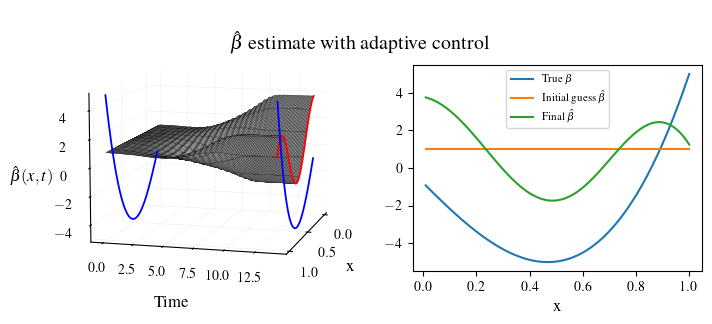

In [157]:
bHat= np.array(bHat)
bHat2 = np.array(bHat2)

res = 1
fig = plt.figure(figsize=set_size(516, 0.99, (1, 2), height_add=1))
subfigs = fig.subfigures(nrows=1, ncols=2, hspace=0)
subfig = subfigs[0]
subfig.subplots_adjust(left=0.15, bottom=0, right=1, top=1.1)
# subfig.suptitle(r"$\hat{\beta}$ estimate with adaptive control for $\sigma=2.9, 3.1$")
axes = subfig.subplots(nrows=1, ncols=1, subplot_kw={"projection": "3d", "computed_zorder": False})

for axis in [axes.xaxis, axes.yaxis, axes.zaxis]:
    axis._axinfo['axisline']['linewidth'] = 1
    axis._axinfo['axisline']['color'] = "b"
    axis._axinfo['grid']['linewidth'] = 0.2
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = "#d1d1d1"
    axis.set_pane_color((0, 0, 0))
    
meshx, mesht = np.meshgrid(spatial, temporal)
                     
axes.plot_surface(meshx, mesht, bHat, edgecolor="black",lw=0.2, rstride=100, cstride=10, 
                        alpha=1, color="white", shade=False, rasterized=True, antialiased=True)
axes.view_init(10, 15)
axes.set_xlabel("x")
axes.set_ylabel("Time", labelpad=10)
axes.set_zlabel(r"$\hat{\beta}(x, t)$")
axes.zaxis.set_rotate_label(False)
axes.set_xticks([0, 0.5, 1])
axes.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
beta = solveBetaFunction(spatial, 2.9)
vals = (bHat)[-1]
test = np.ones(int(nx))*temporal[-1]

axes.plot(spatial, test, vals, color="red", lw=1.3, antialiased=True)
axes.plot(spatial, test, beta, color="blue", lw=1.3, antialiased=True)
axes.plot(spatial, np.zeros(int(nx)), beta, color="blue", lw=1.3, antialiased=True)


subfig = subfigs[1]
# subfig.suptitle(r"Comparison of initial and final $\hat{\beta}$ for $\sigma=2.9, 3.1$")

subfig.subplots_adjust(left=0.15, bottom=0.2, right=0.97, top=0.85, wspace=0.3, hspace=0.1)
axes = subfig.subplots(nrows=1, ncols=1)
beta = solveBetaFunction(spatial, 2.9)
axes.plot(spatial, beta, label=r"True $\beta$")
axes.plot(spatial, np.ones(len(beta)), label=r"Initial guess $\hat{\beta}$")
axes.plot(spatial, bHat[-1], label=r"Final  $\hat{\beta}$")
axes.legend()
axes.set_xlabel("x")

subfig.suptitle(r"$\hat{\beta}$ estimate with adaptive control", x=0, y=0.96, ha="center")
plt.savefig("betaComparisonTight.pdf", dpi=300)

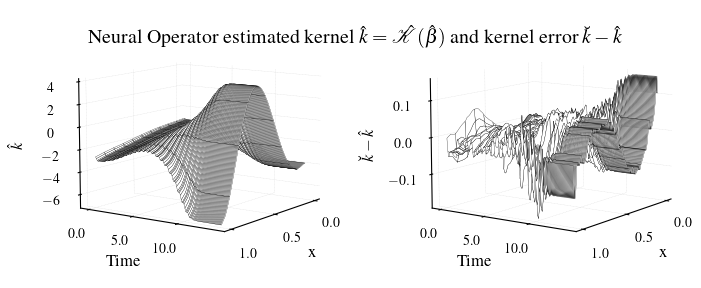

In [155]:
res = 1
fig = plt.figure(figsize=set_size(516, 0.99, (1,2), height_add=0.5))

subfigs = fig.subfigures(nrows=1, ncols=2, hspace=0)

subfig = subfigs[0]
subfig.subplots_adjust(left=0.16, bottom=0, right=0.95, top=1, wspace=0.1, hspace=0)
k = np.array(k)
k2 = np.array(k2)
kNop = np.array(kNop)
kNop2 = np.array(kNop2)

axes = subfig.subplots(nrows=1, ncols=1, subplot_kw={"projection": "3d", "computed_zorder": False})

for axis in [axes.xaxis, axes.yaxis, axes.zaxis]:
    axis._axinfo['axisline']['linewidth'] = 1
    axis._axinfo['axisline']['color'] = "b"
    axis._axinfo['grid']['linewidth'] = 0.2
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = "#d1d1d1"
    axis.set_pane_color((0, 0, 0))
    
meshx, mesht = np.meshgrid(spatial, temporal[1:])
                     
axes.plot_surface(meshx, mesht, kNop, edgecolor="black",lw=0.2, rstride=200, cstride=10, 
                        alpha=1, color="white", shade=False, rasterized=True, antialiased=True)
axes.view_init(10, 35)
axes.set_xlabel("x")
axes.set_ylabel("Time")
axes.set_zlabel(r"$\hat{k}$", rotation=90)
axes.zaxis.set_rotate_label(False)
axes.set_xticks([0, 0.5, 1])
axes.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

subfig = subfigs[1]
axes = subfig.subplots(nrows=1, ncols=1, subplot_kw={"projection": "3d", "computed_zorder": False})
for axis in [axes.xaxis, axes.yaxis, axes.zaxis]:
    axis._axinfo['axisline']['linewidth'] = 1
    axis._axinfo['axisline']['color'] = "b"
    axis._axinfo['grid']['linewidth'] = 0.2
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = "#d1d1d1"
    axis.set_pane_color((0, 0, 0))
subfig.subplots_adjust(left=0.14, bottom=0, right=0.96, top=1, wspace=0.1, hspace=0)
axes.plot_surface(meshx, mesht, k-kNop, edgecolor="black",lw=0.2, rstride=200, cstride=10, 
                        alpha=1, color="white", shade=False, rasterized=True, antialiased=True)
axes.view_init(10, 35)
axes.set_xlabel("x")
axes.set_ylabel("Time")
axes.set_zlabel(r"$\breve k-\hat{k}$", rotation=90)
axes.zaxis.set_rotate_label(False)
axes.set_xticks([0, 0.5, 1])
axes.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
subfig.suptitle(r"Neural Operator estimated kernel $\hat{k}=\hat{\mathcal{K}}(\hat{\beta})$ and kernel error $\breve{k}-\hat{k}$", x=0, y=0.95, ha="center")

plt.savefig("adaptiveKernelsTight.pdf", dpi=300)

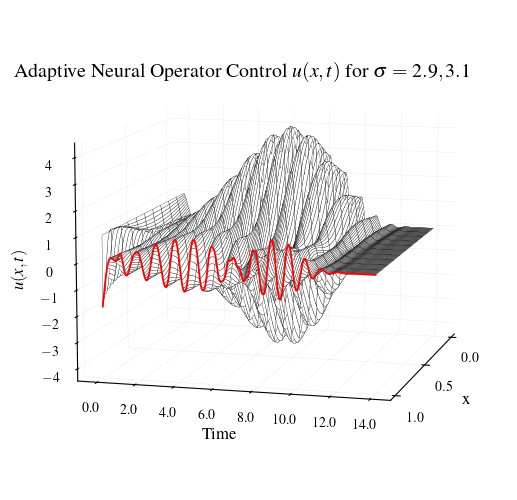

In [160]:
res = 1
fig = plt.figure(figsize=set_size(516, 0.99, (1,1), height_add=0))

subfigs = fig.subfigures(nrows=1, ncols=1, hspace=0)

subfig = subfigs
subfig.subplots_adjust(left=0.07, bottom=0, right=1, top=1.1)
subfig.suptitle(r"Adaptive Neural Operator Control $u(x, t)$ for $\sigma=2.9, 3.1$")
axes = subfig.subplots(nrows=1, ncols=1, subplot_kw={"projection": "3d", "computed_zorder": False})

for axis in [axes.xaxis, axes.yaxis, axes.zaxis]:
    axis._axinfo['axisline']['linewidth'] = 1
    axis._axinfo['axisline']['color'] = "b"
    axis._axinfo['grid']['linewidth'] = 0.2
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = "#d1d1d1"
    axis.set_pane_color((0, 0, 0))
    
meshx, mesht = np.meshgrid(spatial, temporal)
                     
axes.plot_surface(meshx, mesht, uNop, edgecolor="black",lw=0.2, rstride=70, cstride=10, 
                        alpha=1, color="white", shade=False, rasterized=True, antialiased=True)
test = np.ones(nt)
vals = (uNop.transpose())[-1] 
axes.plot(test[1:], temporal[1:], vals[1:], color="red", lw=1.3, antialiased=True)
axes.view_init(10, 15)
axes.set_xlabel("x")
axes.set_ylabel("Time")
axes.set_zlabel(r"$u(x, t)$", rotation=90)
axes.zaxis.set_rotate_label(False)
axes.set_xticks([0, 0.5, 1])
axes.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

plt.savefig("adaptiveControlComparisonTight.pdf", dpi=300)